# Homework 2
Prakhar Sinha  
Professor Hamed Pirsiavash  
SQ 2023  
May 22nd 2023  

### Imports

In [3]:
import numpy as np
import utils
import cv2 as cv
from PIL import Image 
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from scipy.ndimage import rank_filter
from scipy.stats import norm
from utils import harris, dist2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import numpy as np
import random

### Helper Functions

In [4]:
# show and save a ndarray as an image
def img_save(img_array, file_name, title= '', show = True, cmap=None, dtype = np.uint8):
    
    if show:
        plt.imshow(img_array.astype(dtype), cmap = cmap)
        plt.title(title)
        plt.show()
    
    plt.imsave(file_name, img_array.astype(dtype), cmap = cmap)

In [5]:
def draw_corners(img, r, c, ret=False):
    img_copy = img.copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    for i in range(0, len(r)):
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    if ret == True:
        return img_copy
    ax.imshow(img_copy, cmap='gray')

In [6]:
def warp_img(image_left, H):
    # this part of code is referenced from Ajinkya Tejankar
    # get the height and width of the image
    # this function will work with color images
    # so, having third color channel is not a problem
    h_left, w_left = image_left.shape[:2]

    # we want to find where the image corners are going to land
    # so, we create a matrix of four corner points
    C_left = np.array([
        [0, 0     , w_left, w_left],
        [0, h_left, 0     , h_left],
        [1, 1     , 1     , 1     ]
    ])

    # apply the homography to the corner points to get projected corner points
    Cp_left = H @ C_left
    Cp_left = Cp_left / Cp_left[-1, :]

    # find the minimum height and width of the projected corners
    w_min, h_min = Cp_left[:-1].min(axis=1).tolist()
    # we might need to properly floor or ceil the floats to prevent
    # the edge pixels from getting cropped but this works for our needs
    # feel free to fix this
    w_min, h_min = int(np.abs(w_min)), int(np.abs(h_min))
    # what's the final warped image size that can hold the full image?
    warped_image_shape = ((h_left + h_min), (w_left + w_min))

    # we create a new homography that applies the translation
    # that would be otherwise cropped by the warp function below
    Ht = np.array([
        [1, 0, w_min],
        [0, 1, h_min],
        [0, 0, 1    ]
    ])
    # apply the translation homography so that the image is warped
    # but does not have a negative translation relative to origin
    Hw = Ht @ H
    # may not be strictly necessary but make sure that (3,3) is 1
    Hw = Hw / Hw[-1, -1]

    # use skimage.transform.ProjectiveTransform to create a transform for the homography Hw
    tform = skimage.transform.ProjectiveTransform(np.linalg.inv(Hw))
    # use skimage.transform.warp to apply the transform
    warped_image = skimage.transform.warp(image_left, tform, output_shape=warped_image_shape)

    return warped_image

### Question 1
Load both images, convert to double (in MATLAB) or float (in python) and to grayscale.

In [7]:
def imageLoad2Gray(img: np.array, dtype = np.float32) -> np.array: 
    image = np.asarray(img, dtype = dtype)
    image = rgb2gray(image)
    image /= 255.0
    return image

In [8]:
img1 = Image.open("ECS 174 Homework 2_files\\uttower_left.JPG")
img2 = Image.open("ECS 174 Homework 2_files\\uttower_right.JPG")
left = imageLoad2Gray(img1)
right = imageLoad2Gray(img2)

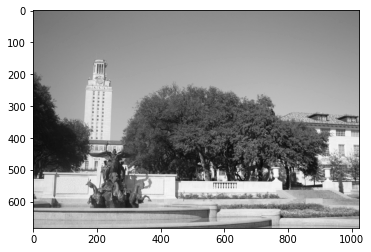

In [9]:
plt.imshow(left, cmap="gray")

### Question 2
Detect feature points in both images. You can use harris.m for Harris corner detection.

In [10]:
def harrisCornerDetection(img1, sigma, thresh=None, radius=None):
    x = utils.harris(img1, sigma, thresh, radius)
    return x

In [11]:
lefty = harrisCornerDetection(left, sigma=3, thresh=0.05, radius=10)
righty = harrisCornerDetection(right, sigma=3, thresh=0.05, radius=10)
cornersLeft = np.vstack((lefty[1], lefty[2])).T
cornersRight = np.vstack((righty[1], righty[2])).T

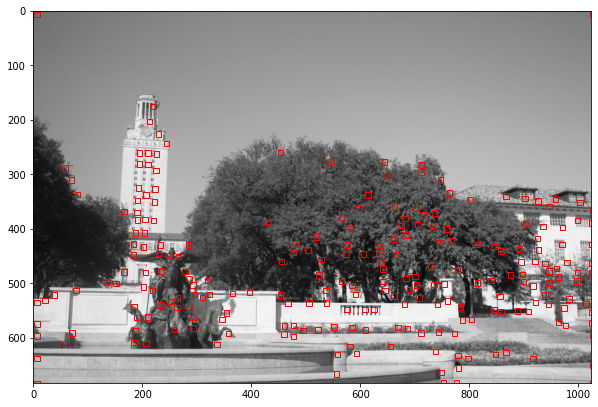

In [12]:
draw_corners(left, lefty[1], lefty[2])

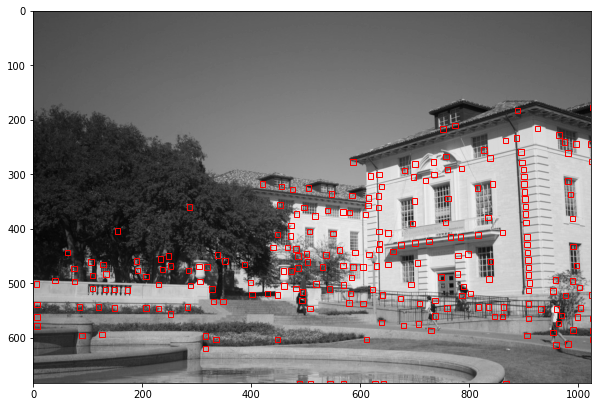

In [13]:
draw_corners(right, righty[1], righty[2])

In [14]:
print(cornersLeft.shape)
print(cornersRight.shape)

(235, 2)
(235, 2)


### Question 3
Extract local neighborhoods around every keypoint in both images, and form descriptors simply by "flattening" the pixel values in each neighborhood to one-dimensional vectors. Experiment with different neighborhood sizes to see which one works the best.

In [15]:
def localNeighborhoodExtract(img1, featureVector1, radius):
    """"featureVector1 and featureVector2 should be the same size ;P"""

    numCorners = featureVector1.shape[0]
    amogusList = []
    amogusIndex = []
    radiusNumber = (2*radius+1)**2
    for i in range(numCorners):
        amogus = featureVector1[i]
        descriptor = (img1[amogus[0] - radius: amogus[0] + radius + 1, amogus[1] - radius : amogus[1] + radius + 1]).flatten()
        if descriptor.any() == False or descriptor.shape[0] != radiusNumber:
            continue
        amogusList.append(descriptor)
        amogusIndex.append(amogus)
    return np.array(amogusList, dtype=list), np.array(amogusIndex, dtype=list)

In [16]:
def SIFT(image, harrisCorners, radius):
    radiusVector = np.full(harrisCorners.shape[0], radius)
    harrisCorners[:,[0,1]] = harrisCorners[:,[1,0]] 
    lol = np.column_stack((harrisCorners, radiusVector))
    return utils.find_sift(image, lol)

In [17]:
leftFeatures = localNeighborhoodExtract(left, cornersLeft, 10)
rightFeatures = localNeighborhoodExtract(right, cornersRight, 10) 
leftDescriptors = leftFeatures[0]
rightDescriptors = rightFeatures[0]
leftCoords = leftFeatures[1]
rightCoords= rightFeatures[1]
print(leftDescriptors.shape, rightDescriptors.shape, leftCoords.shape, rightCoords.shape)

(216, 441) (217, 441) (216, 2) (217, 2)


In [18]:
siftLeft = SIFT(left, cornersLeft, 10)
siftRight= SIFT(right, cornersRight, 10)

### Question 4
 Compute distances between every descriptor in one image and every descriptor in the other image. You can use dist2.m for fast computation of Euclidean distance. Alternatively, experiment with computing normalized correlation, or Euclidean distance after normalizing all descriptors to have zero mean and unit standard deviation. Optionally, feel free to experiment with SIFT descriptors. Here is some find_sift.m for computing SIFT descriptors of circular regions.


In [19]:
def descriptorDist(features2, features1):
    fee = utils.dist2(features1, features2)
    return fee

In [20]:
distanceSift = descriptorDist(siftLeft, siftRight)

### Question 5

Select putative matches based on the matrix of pairwise descriptor distances obtained above. You can select all pairs whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances.

In [21]:
def selectDistances(distanceVector, threshold, coordsLeft, coordsRight):
    thresholded = []
    for i in range(distanceVector.shape[0]):
        for j in range(distanceVector.shape[1]):
            if distanceVector[i][j] <= threshold:
                thresholded.append((coordsLeft[i], coordsRight[j]))
    return np.array(thresholded, dtype=list)

In [22]:
sillySift = selectDistances(distanceSift, 0.1, cornersLeft, cornersRight)

In [23]:
r1 = []
c1 = []
r2 = []
c2 = []
Hd = []
Sd = []
for items in sillySift:
    coord1 = items[0]
    coord2 = items[1] 
    c1.append(coord1[0])
    r1.append(coord1[1])
    Hd.append((coord1[0], coord1[1]))
    c2.append(coord2[1])
    r2.append(coord2[0])
    Sd.append((coord2[0], coord2[1]))


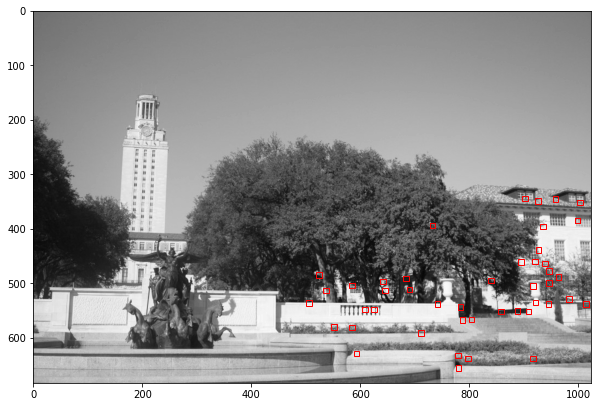

In [24]:
draw_corners(left, r1, c1)

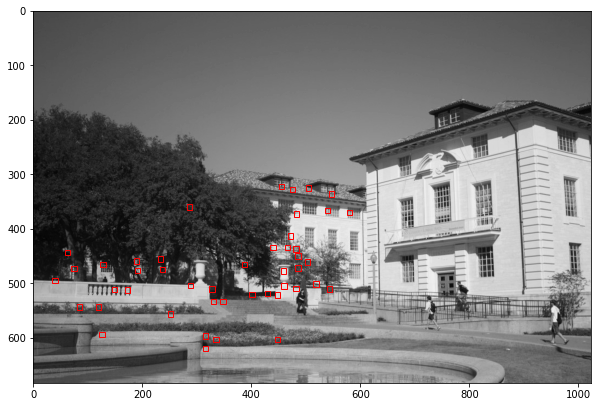

In [25]:
draw_corners(right, c2, r2)

### Question 6
Run RANSAC to estimate a homography mapping one image onto the other. You need to weite the code for RANSAC by yourself. Report the number of inliers and the average residual for the inliers (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.

In [26]:
def RANSAC(matches, threshold, numLoops):
    matchesCopy = matches
    inliersCount = 0
    homography = 0
    bestResidual = 0
    inliersCountTEMP= 0
    H = 0
    inliersTEMP = []
    inliers = []
    src = []
    dest = []

    for i in range(numLoops):
        seed1 = random.randint(0, len(matches) - 1)
        xy1 = matches[seed1]
        seed2 = random.randint(0, len(matches) - 1)
        if seed2 == seed1:
            seed2 = random.randint(0, len(matches) - 1)
        xy2 = matches[seed2]

        x_i = xy1[0][0]
        x_iPrime = xy1[0][1]
        y_i = xy2[0][0]
        y_iPrime = xy2[0][1]  
        
        c0 = np.array([x_i, 0], dtype=np.float32)
        c1 = np.array([y_i, 0], dtype=np.float32)
        c2 = np.array([1, 0], dtype=np.float32)
        c3 = np.array([0, x_i], dtype=np.float32)
        c4 = np.array([0, y_i], dtype=np.float32)
        c5 = np.array([0, 1], dtype=np.float32)
        c6 = np.array([-x_iPrime*x_i, -y_iPrime*x_i], dtype=np.float32)
        c7 = np.array([-x_iPrime*y_i, -y_iPrime*y_i], dtype=np.float32)
        c8 = np.array([-x_iPrime, -y_iPrime], dtype=np.float32)

        A = np.row_stack((c0, c1, c2, c3, c4, c5, c6, c7, c8)).T
        _, _, vh = np.linalg.svd(A, compute_uv=True, full_matrices=True)
        H = vh[8].reshape((3,3))

        inliersCountTEMP = 0
        meanDistTEMP = []
        srcTEMP = []
        destTEMP = []
        for coordinates in matchesCopy:
            xNew = coordinates[0][0]
            yNew = coordinates[0][1]
            xNew_P = coordinates[1][0]
            yNew_P = coordinates[1][1]
            multiplicand = np.array([xNew, yNew, 1])
            uvhMatix = np.matmul(H, multiplicand)
            uvhIfItWasDivided = np.divide(uvhMatix, uvhMatix[2])
            xPred = uvhIfItWasDivided[0]
            yPred = uvhIfItWasDivided[1]

            dist = np.sqrt(((xNew_P - xPred)**2 + (yNew_P - yPred)**2))

            # print(dist)
            if dist < threshold:
                inliersCountTEMP += 1
                srcTEMP.append((xNew, yNew))
                destTEMP.append((xNew_P, yNew_P))
               
        if inliersCountTEMP > inliersCount:
            inliersCount = inliersCountTEMP
            homography = H
            bestResidual = np.mean(np.array(meanDistTEMP, dtype=list))
            src = srcTEMP
            dest = destTEMP

    return homography, bestResidual, src, dest

In [27]:
H, resdid, src, dest = RANSAC(sillySift, 550, 500)

c:\Users\sinha\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sinha\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:191: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


In [28]:
src = np.array(src)
dest = np.array(dest)
H, _ = cv.findHomography(src, dest, cv.RANSAC, 3)

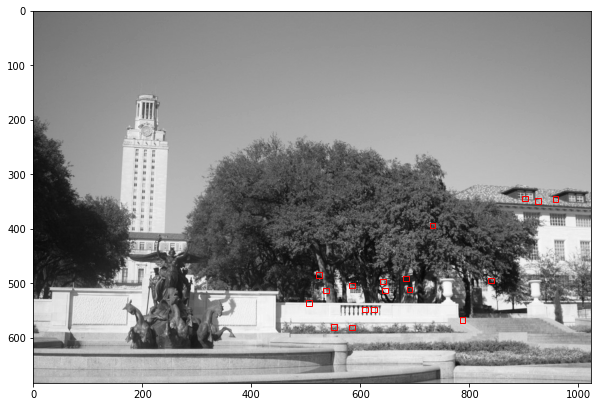

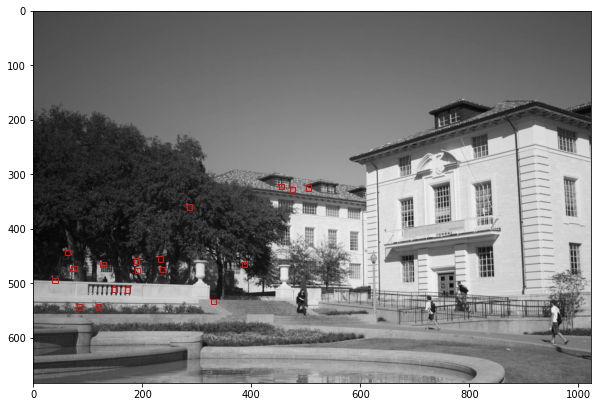

In [29]:
r1 = []
c1 = []
for x in src:
    c1.append(x[0])
    r1.append(x[1])

r2 = []
c2 = []
for y in dest:
    c2.append(y[0])
    r2.append(y[1]) 

draw_corners(left, r1, c1)
draw_corners(right, r2, c2)


In [30]:
len(src), len(dest)

(18, 18)

### Question 7
Warp one image onto the other using the estimated transformation. To do this, you will need to learn about maketform and imtransform functions in MATLAB or similar functions in Python. You can use off-the-shelf code for this transformation (warping).

<class 'numpy.ndarray'>


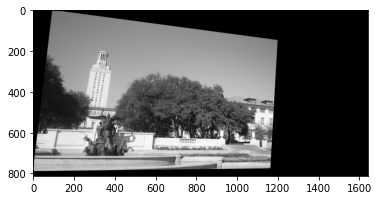

In [31]:
warped_img1 = warp_img(left, H)
print(type(warped_img1))
plt.imshow(warped_img1, cmap='gray')

### Question 8
Create a new image big enough to hold the panorama and composite the two images into it. You can composite by simply averaging the pixel values where the two images overlap. Your result should look something like this (but hopefully with a more precise alignment):

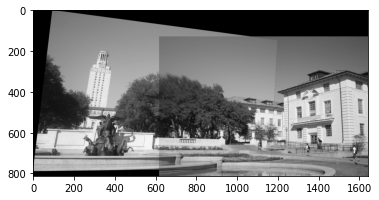

In [32]:
naur = cv.copyMakeBorder(right, warped_img1.shape[0] - right.shape[0], 0, warped_img1.shape[1] - right.shape[1], 0, cv.BORDER_CONSTANT)
yaur = warped_img1
k = np.empty(shape=naur.shape, dtype=np.float32)
for i in range(naur.shape[0]):
    for j in range(naur.shape[1]):
        if naur[i][j] != 0 and yaur[i][j] != 0:
            k[i][j] = (naur[i][j] + yaur[i][j])/2
        elif naur[i][j] != 0 and yaur[i][j] == 0:
            k[i][j] = naur[i][j]
        elif naur[i][j] == 0 and yaur[i][j] != 0:
            k[i][j] = yaur[i][j]
        
plt.imshow(k, cmap="gray")  